## **Emotion Recognition and Emoji Recommendation**

---

[Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## 1. Installing Hugging Face's nlp package

In [2]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Importing the libraries

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 3. Importing the Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pickle

with open('/content/drive/MyDrive/merged_training.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
data.text.head()

27383     i feel awful about it too because it s my job ...
110083                                im alone i feel awful
140764    ive probably mentioned this before but i reall...
100071             i was feeling a little low few days back
2837      i beleive that i am much more sensitive to oth...
Name: text, dtype: object

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((333447, 2), (83362, 2))

In [27]:
train['text']

13704                                   i feel nostalgic an
4526      i am before the blessed sacra ment i feel such...
133325      im feeling so excited for you card side by side
97515     i visit the school i feel a little heartbroken...
33703     i feel content with myself and the people arou...
                                ...                        
97113     i love the feeling that im not adding any more...
19783                                  i do not feel woeful
42853     i feel its for you to learn from and grow and ...
37834     i feel kinda regretful that i spent less time ...
1751      when i was put into a tennis team below my sta...
Name: text, Length: 333447, dtype: object

In [28]:
def get_tweets(data):
    tweets = [x for x in data['text']]
    labels = [x for x in data['emotions']]
    return tweets, labels

In [29]:
tweets, labels = get_tweets(train)

In [30]:
tweets[10], labels[10]

('i read in the newspaper about a yr old woman who was found naked and dead along a roadside it turned out she had had two relatives and who were kidnapped',
 'anger')

## 4. Tokenizing the Tweets

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 233, 12, 6, 4495, 28, 7, 7979, 317, 518, 75, 21, 291, 2162, 4, 1351, 613, 7, 1, 13, 988, 49, 98, 58, 58, 222, 4298, 4, 75, 133, 1]]


## 5. Padding and Truncating Sequences

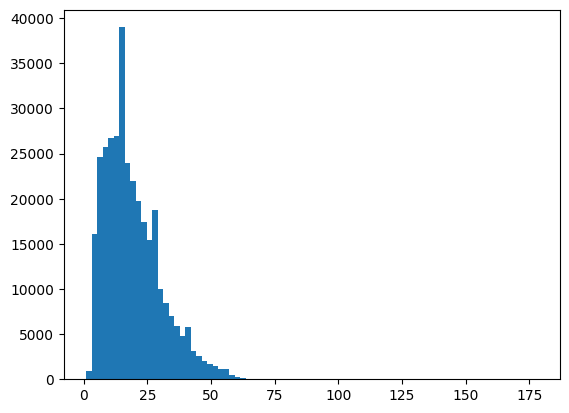

In [33]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [36]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [37]:
padded_train_sequences[10]

array([   2,  233,   12,    6, 4495,   28,    7, 7979,  317,  518,   75,
         21,  291, 2162,    4, 1351,  613,    7,    1,   13,  988,   49,
         98,   58,   58,  222, 4298,    4,   75,  133,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## 6. Preparing the Labels

In [38]:
classes = set(labels)
print(classes)

{'anger', 'sadness', 'joy', 'surprise', 'love', 'fear'}


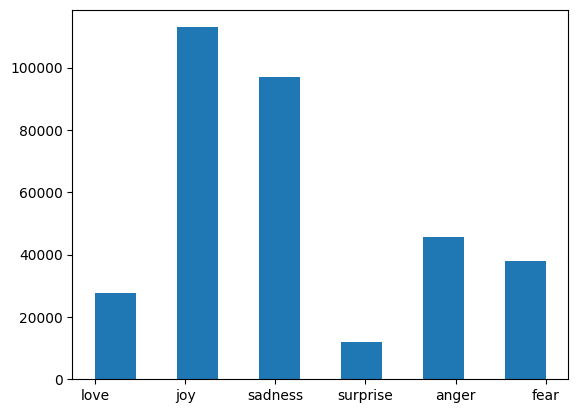

In [39]:
plt.hist(labels, bins=11)
plt.show()

In [40]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [41]:
classes_to_index

{'anger': 0, 'sadness': 1, 'joy': 2, 'surprise': 3, 'love': 4, 'fear': 5}

In [42]:
index_to_classes

{0: 'anger', 1: 'sadness', 2: 'joy', 3: 'surprise', 4: 'love', 5: 'fear'}

In [43]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [44]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


## 7. Creating the Model

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## 8. Training the Model

In [49]:
h = model.fit(
    padded_train_sequences, train_labels,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/30
10421/10421 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8889

10421/10421 [==============================] - 178s 16ms/step - loss: 0.2714 - accuracy: 0.8889
Epoch 2/30
10421/10421 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9352

10421/10421 [==============================] - 135s 13ms/step - loss: 0.1093 - accuracy: 0.9352
Epoch 3/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9393

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0965 - accuracy: 0.9393
Epoch 4/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9409

10421/10421 [==============================] - 136s 13ms/step - loss: 0.0916 - accuracy: 0.9409
Epoch 5/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9422

10421/10421 [==============================] - 140s 13ms/step - loss: 0.0886 - accuracy: 0.9422
Epoch 6/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9427

10421/10421 [==============================] - 137s 13ms/step - loss: 0.0864 - accuracy: 0.9427
Epoch 7/30
10420/10421 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9427

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0848 - accuracy: 0.9427
Epoch 8/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9434

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0836 - accuracy: 0.9434
Epoch 9/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9435

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0825 - accuracy: 0.9435
Epoch 10/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9442

10421/10421 [==============================] - 135s 13ms/step - loss: 0.0820 - accuracy: 0.9442
Epoch 11/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9446

10421/10421 [==============================] - 133s 13ms/step - loss: 0.0811 - accuracy: 0.9446
Epoch 12/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9445

10421/10421 [==============================] - 132s 13ms/step - loss: 0.0808 - accuracy: 0.9445
Epoch 13/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9449

10421/10421 [==============================] - 137s 13ms/step - loss: 0.0801 - accuracy: 0.9449
Epoch 14/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9451

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0796 - accuracy: 0.9451
Epoch 15/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9461

10421/10421 [==============================] - 141s 14ms/step - loss: 0.0791 - accuracy: 0.9461
Epoch 16/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9456

10421/10421 [==============================] - 135s 13ms/step - loss: 0.0787 - accuracy: 0.9456
Epoch 17/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9464

10421/10421 [==============================] - 144s 14ms/step - loss: 0.0784 - accuracy: 0.9464
Epoch 18/30
10418/10421 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9462

10421/10421 [==============================] - 146s 14ms/step - loss: 0.0782 - accuracy: 0.9462
Epoch 19/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9466

10421/10421 [==============================] - 138s 13ms/step - loss: 0.0783 - accuracy: 0.9466
Epoch 20/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9468

10421/10421 [==============================] - 137s 13ms/step - loss: 0.0779 - accuracy: 0.9468
Epoch 21/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9471

10421/10421 [==============================] - 138s 13ms/step - loss: 0.0776 - accuracy: 0.9471
Epoch 22/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9476

10421/10421 [==============================] - 136s 13ms/step - loss: 0.0770 - accuracy: 0.9476
Epoch 23/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9473

10421/10421 [==============================] - 133s 13ms/step - loss: 0.0766 - accuracy: 0.9473
Epoch 24/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9471

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0766 - accuracy: 0.9471
Epoch 25/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9480

10421/10421 [==============================] - 148s 14ms/step - loss: 0.0764 - accuracy: 0.9480
Epoch 26/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9485

10421/10421 [==============================] - 156s 15ms/step - loss: 0.0759 - accuracy: 0.9485
Epoch 27/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9485

10421/10421 [==============================] - 162s 16ms/step - loss: 0.0755 - accuracy: 0.9485
Epoch 28/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9486

10421/10421 [==============================] - 137s 13ms/step - loss: 0.0757 - accuracy: 0.9486
Epoch 29/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9489

10421/10421 [==============================] - 134s 13ms/step - loss: 0.0754 - accuracy: 0.9489
Epoch 30/30
10421/10421 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9487

10421/10421 [==============================] - 139s 13ms/step - loss: 0.0753 - accuracy: 0.9487


## 9. Evaluating the Model

In [51]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [52]:
eval = model.evaluate(test_sequences, test_labels)

2606/2606 [==============================] - 18s 6ms/step - loss: 0.1646 - accuracy: 0.9212


In [68]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = np.argmax(model.predict(np.expand_dims(test_sequences[i], axis=0))[0],axis=-1)
  
  print('Predicted Emotion:', index_to_classes.get(p), '\n')

Tweet: i need in an area i feel uncomfortable
Actual Emotion: fear
1/1 [==============================] - 0s 21ms/step
Predicted Emotion: fear 

Tweet: i feel very lucky to have good lecturer that always willing to teach us and provide us with good guidance and advice on my academic
Actual Emotion: joy
1/1 [==============================] - 0s 24ms/step
Predicted Emotion: joy 

Tweet: i feel proud about my collection when others come over and say no wonder youre so smart
Actual Emotion: joy
1/1 [==============================] - 0s 21ms/step
Predicted Emotion: joy 

Tweet: i feel a welcomed obligation to learn spanish
Actual Emotion: joy
1/1 [==============================] - 0s 21ms/step
Predicted Emotion: joy 

Tweet: i feel quite vulnerable sharing this here
Actual Emotion: fear
1/1 [==============================] - 0s 21ms/step
Predicted Emotion: fear 



In [69]:
preds = np.argmax(model.predict(test_sequences),axis=-1)
preds.shape, test_labels.shape

2606/2606 [==============================] - 16s 6ms/step


((83362,), (83362,))

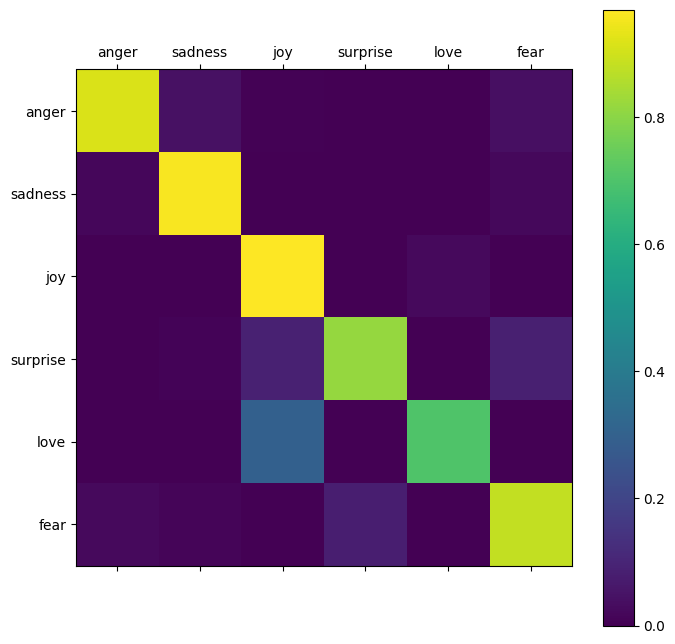

In [70]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
show_confusion_matrix(test_labels, preds, list(classes))

## 10. Emoji Recommendation

In [75]:
!pip install unrar
!unrar x '/content/drive/MyDrive/Emojis.rar'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/drive/MyDrive/Emojis.rar

Creating    Emojis                                                    OK
Extracting  Emojis/Angry-1.png                                             3%  OK 
Extracting  Emojis/Angry-2.png                                             6%  OK 
Extracting  Emojis/Angry-3.png                                             9%  OK 
Extracting  Emojis/Angry-4.png                                            11%  OK 
Extracting  Emojis/Angry-5.png                                            15%  OK 
Extracting  Emojis/Fear-1.png                                             18%  OK 
Extracting  Emojis/Fear-2.png                                             22%  OK 
Extracting  Emojis/Fear-3.png                            

Tweet: i both feel that neither screeching nor throwing things is acceptable
Actual Emotion: joy
1/1 [==============================] - 0s 54ms/step
Predicted Emotion: joy 



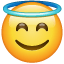

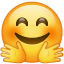

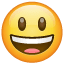

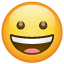

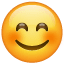

In [87]:
import os
from PIL import Image
from os import listdir

i = random.randint(0, len(test_labels) - 1)
print('Tweet:', test_tweets[i])
print('Actual Emotion:', index_to_classes[test_labels[i]])
p = np.argmax(model.predict(np.expand_dims(test_sequences[i], axis=0))[0],axis=-1)
print('Predicted Emotion:', index_to_classes.get(p), '\n')
pred_emo=index_to_classes.get(p)
dic={'anger': 'Angry', 'sadness': 'Sad', 'joy': 'Happy', 'surprise': 'Surprise', 'love': 'Love', 'fear': 'Fear'}
find_img=dic[pred_emo]

folder_dir = "/content/Emojis"
for images in os.listdir(folder_dir):
    if (images.startswith(find_img)):
      path = folder_dir+'/'+images
      img = Image.open(path)
      img.show()